# Weather Time Series Analysis and Forecasting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
import warnings
warnings.filterwarnings("ignore")

here we are cleaning the original dataset and getting the cleaned one

In [5]:

original_df = pd.read_csv("/content/drive/MyDrive/weather.csv")

# Define renaming map (remove units, simplify names, drop 'OT')
rename_map = {
    'p (mbar)': 'p',
    'T (degC)': 'T',
    'Tpot (K)': 'Tpot',
    'Tdew (degC)': 'Tdew',
    'rh (%)': 'rh',
    'VPmax (mbar)': 'VPmax',
    'VPact (mbar)': 'VPact',
    'VPdef (mbar)': 'VPdef',
    'sh (g/kg)': 'sh',
    'H2OC (mmol/mol)': 'H2OC',
    'rho (g/m**3)': 'rho',
    'wv (m/s)': 'wv',
    'max. wv (m/s)': 'max. wv',
    'wd (deg)': 'wd',
    'rain (mm)': 'rain',
    'raining (s)': 'raining',
    'SWDR (W/m�)': 'SWDR',
    'PAR (�mol/m�/s)': 'PAR',
    'max. PAR (�mol/m�/s)': 'max. PAR',
    'Tlog (degC)': 'Tlog',
    'OT': None  # Drop this column
}

# Clean the dataset in-memory
cleaned_df = original_df.rename(columns={k: v for k, v in rename_map.items() if v})
cleaned_df = cleaned_df.drop(columns=[k for k, v in rename_map.items() if v is None])

# Convert 'date' to datetime and set as index
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
cleaned_df.set_index('date', inplace=True)

# Add derived time features
cleaned_df['hour'] = cleaned_df.index.hour
cleaned_df['month'] = cleaned_df.index.month
cleaned_df['day'] = cleaned_df.index.day

cleaned_df.head()


,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,...,wd,rain,raining,SWDR,PAR,max. PAR,Tlog,hour,month,day
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,...,224.3,0.0,0.0,0.0,0.0,0.0,11.45,0,1,1
2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,...,206.8,0.0,0.0,0.0,0.0,0.0,11.51,0,1,1
2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,...,197.1,0.0,0.0,0.0,0.0,0.0,11.60,0,1,1
2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,...,206.4,0.0,0.0,0.0,0.0,0.0,11.70,0,1,1
2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,...,209.6,0.0,0.0,0.0,0.0,0.0,11.81,0,1,1


here both the datasets are given and the difference is plotted


In [6]:
import pandas as pd

# Load both datasets
original = pd.read_csv("/content/drive/MyDrive/weather.csv")
cleaned = pd.read_csv("/content/drive/MyDrive/cleaned_weather.csv")

# Compare column names
print(" Columns in Original:\n", original.columns.tolist())
print("\n Columns in Cleaned:\n", cleaned.columns.tolist())

# Compare shapes
print(f"\nOriginal shape: {original.shape}")
print(f"Cleaned shape:  {cleaned.shape}")

# Check column differences
set_orig = set(original.columns)
set_clean = set(cleaned.columns)

added = set_clean - set_orig
removed = set_orig - set_clean
print(f"\n Removed Columns: {removed}")
print(f" Added/Updated Columns: {added}")

# Compare sample values
print("\n Sample data from original:")
display(original.head(2))
print("\n Sample data from cleaned:")
display(cleaned.head(5))


 Columns in Original:
 ['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m�)', 'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT']

 Columns in Cleaned:
 ['date', 'p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh', 'H2OC', 'rho', 'wv', 'max. wv', 'wd', 'rain', 'raining', 'SWDR', 'PAR', 'max. PAR', 'Tlog']

Original shape: (52696, 22)
Cleaned shape:  (52696, 21)

 Removed Columns: {'rh (%)', 'Tpot (K)', 'max. PAR (�mol/m�/s)', 'sh (g/kg)', 'raining (s)', 'T (degC)', 'VPdef (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)', 'PAR (�mol/m�/s)', 'wv (m/s)', 'OT', 'p (mbar)', 'rain (mm)', 'SWDR (W/m�)', 'wd (deg)', 'Tlog (degC)', 'VPact (mbar)', 'rho (g/m**3)', 'max. wv (m/s)', 'VPmax (mbar)'}
 Added/Updated Columns: {'rh', 'Tpot', 'VPact', 'SWDR', 'p', 'T', 'sh', 'wd', 'Tdew', 'Tlog'

,date,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0



 Sample data from cleaned:


,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,...,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81


### Basic Statistical Analysis




Basic Statistics:
                  p             T          Tpot          Tdew            rh  \
count  52696.000000  52696.000000  52696.000000  52696.000000  52696.000000   
mean     989.989233     10.818241    284.796938      5.409105     72.487133   
std        9.207149      7.468671      7.616995      5.956722     19.230260   
min      955.580000     -6.440000    266.190000    -13.810000     21.160000   
25%      984.800000      4.590000    278.550000      0.777500     58.820000   
50%      990.920000     10.230000    284.320000      5.260000     75.400000   
75%      995.930000     16.180000    290.260000      9.700000     87.900000   
max     1020.070000     34.800000    309.130000     20.500000    100.000000   

              VPmax         VPact         VPdef            sh          H2OC  \
count  52696.000000  52696.000000  52696.000000  52696.000000  52696.000000   
mean      14.487046      9.676828      4.810131      6.111159      9.782341   
std        7.632960      4.02350

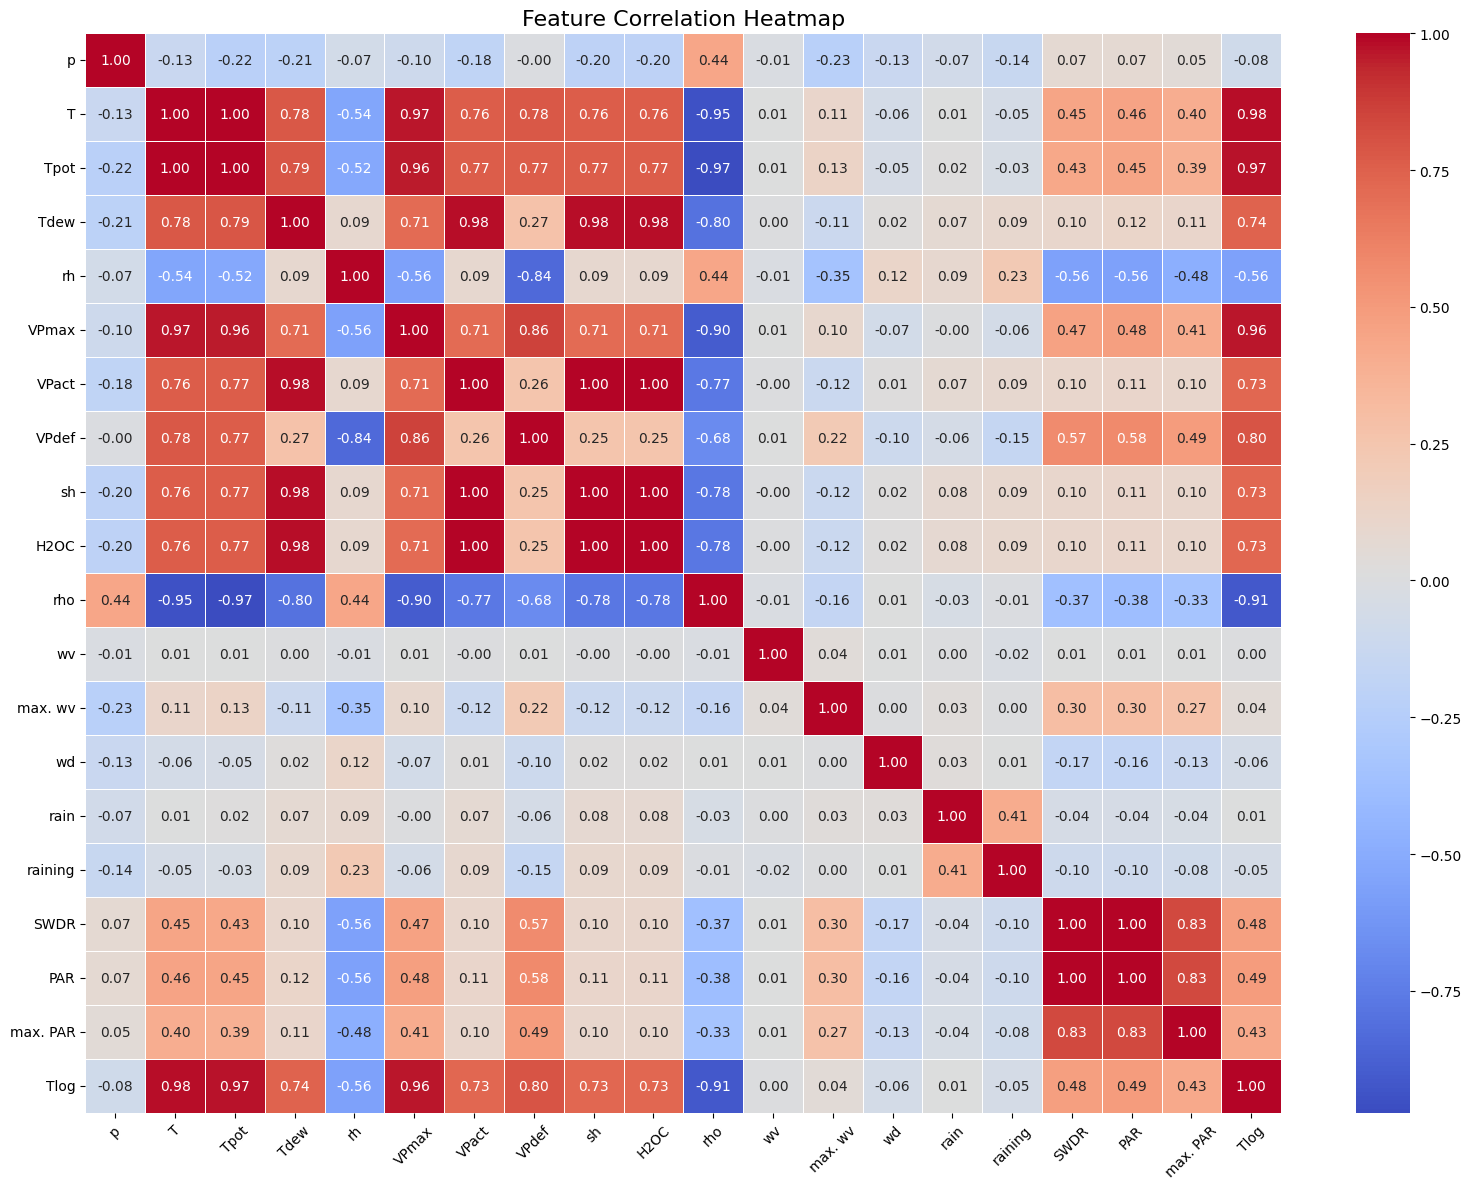

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("/content/drive/MyDrive/cleaned_weather.csv")
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

def basic_statistics(df):
    """
    Calculate basic statistics for numerical columns
    """
    stats_df = df.describe()
    correlations = df.corr()
    return stats_df, correlations

stats_df, correlations = basic_statistics(df)

print("\nBasic Statistics:")
print(stats_df)


print("\n Correlation Matrix:")
print(correlations)


plt.figure(figsize=(16, 12))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [12]:
def basic_statistics(df):
    """
    Calculate basic statistics for numerical columns
    """
    stats_df = df.describe()
    correlations = df.corr()

    return stats_df, correlations

# Basic statistics
stats_df, correlations = basic_statistics(df)
print("\nBasic Statistics:")
stats_df.head()


Basic Statistics:


,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,...,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog,month,hour
count,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,...,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000
mean,989.989233,10.818241,284.796938,5.409105,72.487133,14.487046,9.676828,4.810131,6.111159,9.782341,...,3.632807,176.850276,0.011773,25.907469,131.331822,259.863438,308.601939,21.515206,6.513891,11.500171
std,9.207149,7.468671,7.616995,5.956722,19.230260,7.632960,4.023504,5.539320,2.561536,4.082684,...,2.462467,81.194840,0.123289,111.503420,215.735116,422.786515,569.956762,7.790620,3.451478,6.922783
min,955.580000,-6.440000,266.190000,-13.810000,21.160000,3.770000,2.090000,0.000000,1.300000,2.090000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.900000,1.000000,0.000000
25%,984.800000,4.590000,278.550000,0.777500,58.820000,8.480000,6.460000,1.170000,4.070000,6.530000,...,1.770000,141.100000,0.000000,0.000000,0.000000,0.000000,0.000000,15.240000,4.000000,5.000000


### Analysis of Daily Weather Patterns

In [9]:
def analyze_daily_patterns(df):
    """
    Analyze daily patterns in temperature, humidity, and radiation
    """
    daily_stats = df.resample('D').agg({
        'T': ['mean', 'min', 'max'],
        'rh': 'mean',
        'SWDR': 'sum',
        'rain': 'sum'
    })

    return daily_stats


# Daily patterns
daily_stats = analyze_daily_patterns(df)
print("\nFirst few days of daily statistics:")
daily_stats.head()


First few days of daily statistics:


T                     rh     SWDR rain
                mean   min   max       mean      sum  sum
date                                                     
2020-01-01 -0.514196 -3.46  4.58  86.429301  8250.91  0.0
2020-01-02 -1.056319 -5.78  6.47  80.206042  9570.44  0.0
2020-01-03  4.835278  0.69  8.17  81.975000  1665.99  0.3
2020-01-04  3.784931  1.47  6.61  80.899861  1157.79  4.8
2020-01-05  2.735000  1.47  4.43  76.422639  4572.03  0.0

### Analysis of Extreme Weather Events



In [10]:
def analyze_extreme_events(df):
    """
    Identify and analyze extreme weather events
    """
    extremes = {
        'highest_temp': df['T'].max(),
        'lowest_temp': df['T'].min(),
        'highest_wind': df['wv'].max(),
        'max_daily_rain': df.resample('D')['rain'].sum().max(),
        'hottest_day': df.resample('D')['T'].mean().idxmax(),
        'coldest_day': df.resample('D')['T'].mean().idxmin(),
        'prevailing_wind_direction': df.groupby('wd')['wv'].count().idxmax()
    }

    return extremes

# Extreme events
print("\nExtreme weather events:")
extremes = analyze_extreme_events(df)
for event, value in extremes.items():
    print(f"{event}: {value}")


Extreme weather events:
highest_temp: 34.8
lowest_temp: -6.44
highest_wind: 13.77
max_daily_rain: 46.4
hottest_day: 2020-08-08 00:00:00
coldest_day: 2020-01-25 00:00:00
prevailing_wind_direction: 210.3


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_weather_patterns(df):
    """
    Create visualizations of weather patterns
    """
    # Set Seaborn style
    sns.set(style="whitegrid")

    # Create main figure with three subplots
    fig = plt.figure(figsize=(15, 9))

    # Temperature distribution by month
    ax1 = plt.subplot(231)
    sns.boxplot(data=df, x='month', y='T', ax=ax1)
    ax1.set_title('Temperature Distribution by Month')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Temperature (°C)')

    # Average temperature by hour
    ax2 = plt.subplot(232)
    hourly_temp = df.groupby('hour')['T'].mean()
    ax2.plot(hourly_temp.index, hourly_temp.values)
    ax2.set_title('Average Temperature by Hour')
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Temperature (°C)')

    # Monthly rainfall pattern
    ax3 = plt.subplot(233)
    monthly_rain = df.groupby('month')['rain'].sum()
    ax3.bar(monthly_rain.index, monthly_rain.values)
    ax3.set_title('Total Monthly Rainfall')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Rainfall (mm)')

    return fig


### Weather Prediction Model Implementation



Epoch 1/5
2107/2107 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0045 - val_loss: 1.1569e-04
Epoch 2/5
2107/2107 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 6.1290e-05 - val_loss: 3.2155e-05
Epoch 3/5
2107/2107 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 7.2982e-05 - val_loss: 1.8560e-04
Epoch 4/5
2107/2107 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 5.9371e-05 - val_loss: 5.0356e-05
Epoch 5/5
2107/2107 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.7450e-05 - val_loss: 3.3231e-05
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5
2107/2107 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0027 - val_loss: 5.2986e-05
Epoch 2/5
2107/2107 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 7.1885e-05 - val_loss: 4.5641e-05
Epoch 3/5
2107/2107 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 6.2614e-05 - val_loss: 3.0603e-05
Epoch 4/5
2107/2107 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 5.0280e-05 - val_loss: 2.2539e-05
Epoch 5/5
2107/2107 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 4.4571e-05 - val_loss: 3.7122e-05
330/330 ━━

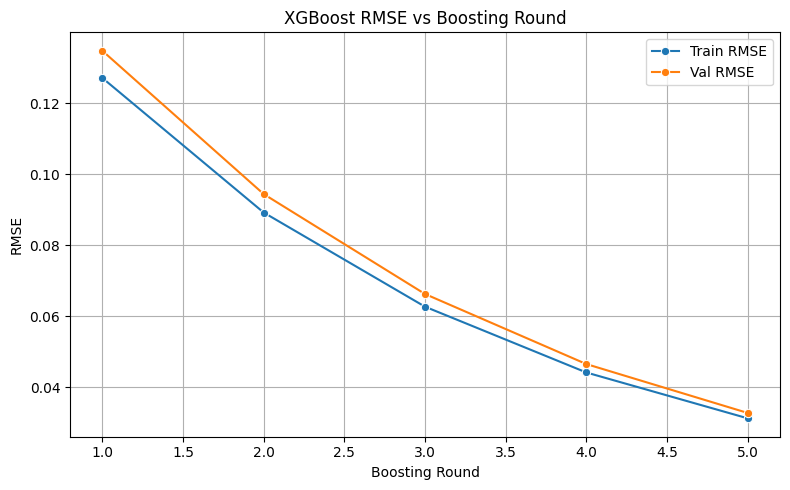

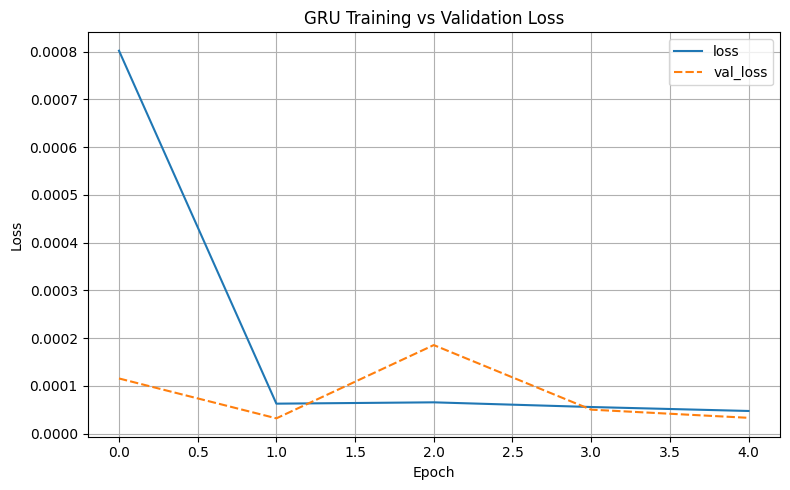

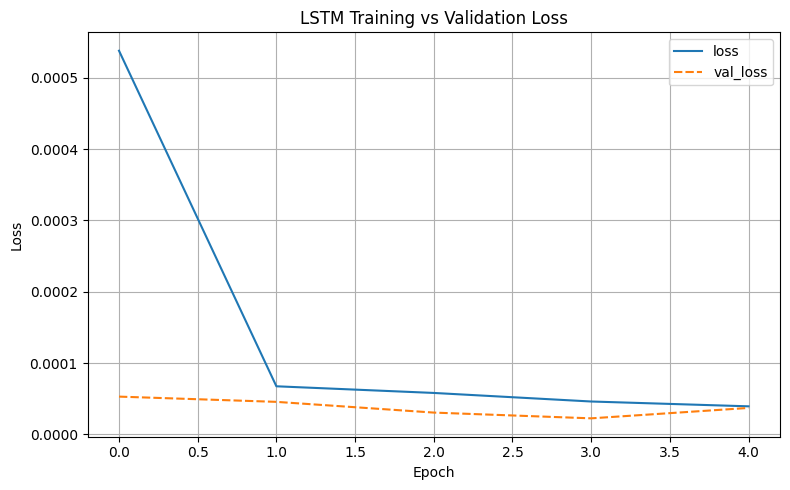

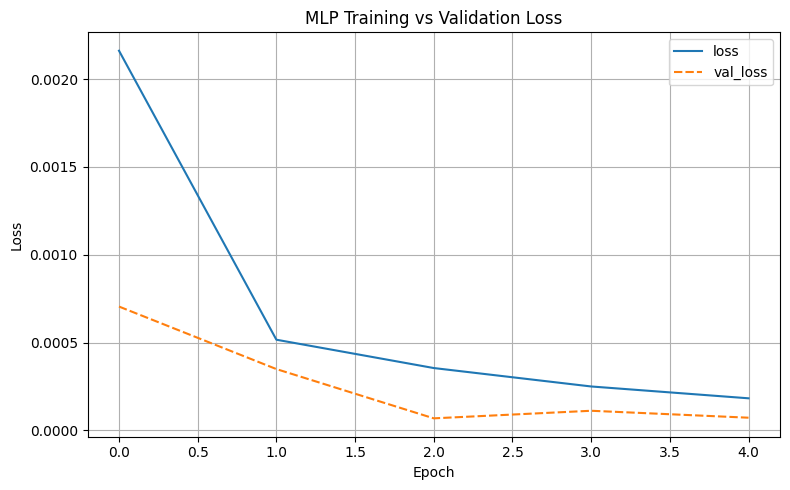

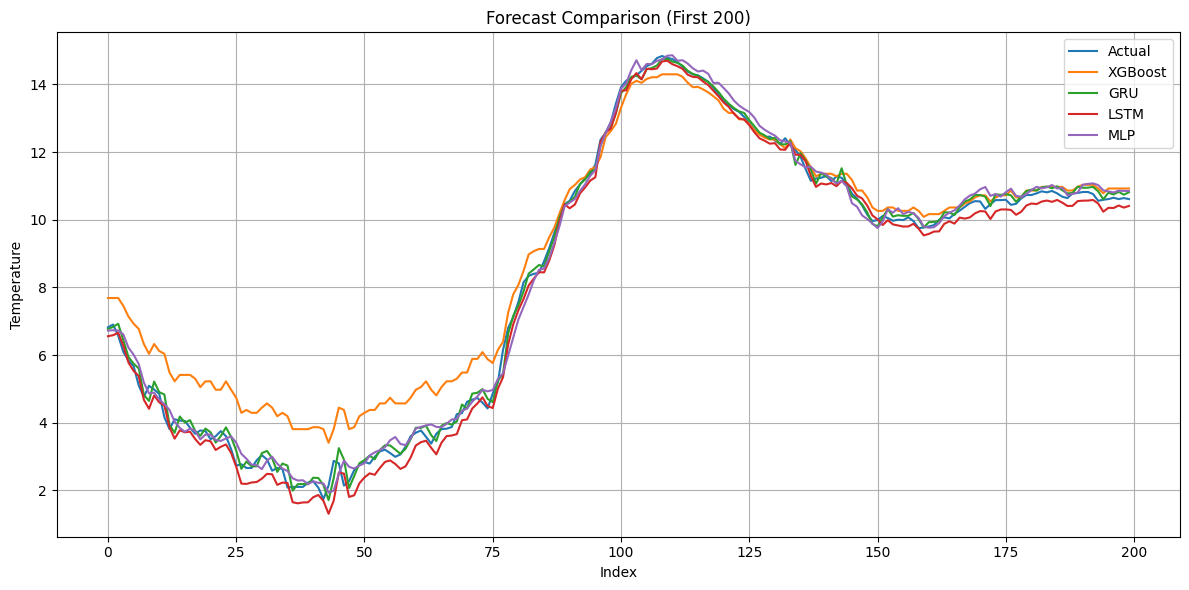

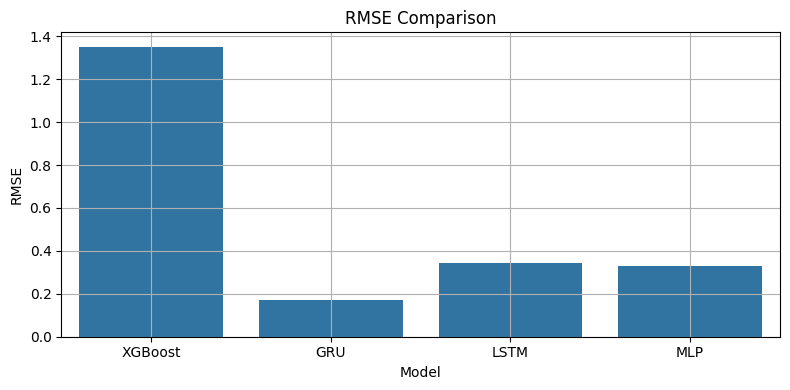

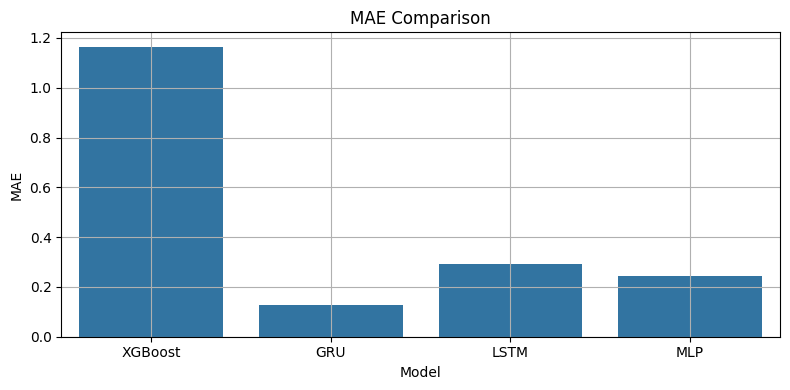

     Model      RMSE       MAE
0  XGBoost  1.350643  1.164520
1      GRU  0.171297  0.127374
2     LSTM  0.341820  0.290553
3      MLP  0.329145  0.244510


In [15]:
# === Combined Model Comparison with Training Histories ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Flatten

# Function to load and prepare data
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['day'] = df.index.day
    return df

# Function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predict the first column (target)
    return np.array(X), np.array(y)

# 1. Load & prepare data
df = load_and_prepare_data('/content/drive/MyDrive/cleaned_weather.csv')

# 2. Define target & features
target = 'T'
features = [c for c in df.columns if c != target]
df_model = df[[target] + features]

# 3. Scale all features to [0,1]
scalers = {}
df_scaled = df_model.copy()
for col in df_model.columns:
    mms = MinMaxScaler()
    df_scaled[col] = mms.fit_transform(df_model[[col]])
    scalers[col] = mms

data = df_scaled.values

# 4. Create sequences
seq_len = 24
X, y = create_sequences(data, seq_len)

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_flat_train = X_train.reshape(X_train.shape[0], -1)
X_flat_test = X_test.reshape(X_test.shape[0], -1)
y_test_inv = scalers[target].inverse_transform(y_test.reshape(-1, 1)).ravel()

results = {}

# 6. XGBoost Model
xgb = XGBRegressor(n_estimators=5, random_state=42, verbosity=0, eval_metric='rmse')
xgb.fit(X_flat_train, y_train, eval_set=[(X_flat_train, y_train), (X_flat_test, y_test)], verbose=False)
xgb_eval = xgb.evals_result()
p_xgb = xgb.predict(X_flat_test)
p_xgb_inv = scalers[target].inverse_transform(p_xgb.reshape(-1, 1)).ravel()
results['XGBoost'] = {
    'pred': p_xgb_inv,
    'rmse': np.sqrt(mean_squared_error(y_test_inv, p_xgb_inv)),
    'mae': mean_absolute_error(y_test_inv, p_xgb_inv)
}

# 7. GRU Model
model_gru = Sequential([
    GRU(64, input_shape=(seq_len, df_scaled.shape[1])),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2, verbose=1)
p_gru = model_gru.predict(X_test)
p_gru_inv = scalers[target].inverse_transform(p_gru).ravel()
results['GRU'] = {
    'pred': p_gru_inv,
    'rmse': np.sqrt(mean_squared_error(y_test_inv, p_gru_inv)),
    'mae': mean_absolute_error(y_test_inv, p_gru_inv)
}

# 8. LSTM Model
model_lstm = Sequential([
    LSTM(64, input_shape=(seq_len, df_scaled.shape[1])),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
history_lstm = model_lstm.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2, verbose=1)
p_lstm = model_lstm.predict(X_test)
p_lstm_inv = scalers[target].inverse_transform(p_lstm).ravel()
results['LSTM'] = {
    'pred': p_lstm_inv,
    'rmse': np.sqrt(mean_squared_error(y_test_inv, p_lstm_inv)),
    'mae': mean_absolute_error(y_test_inv, p_lstm_inv)
}

# 9. MLP Model
model_mlp = Sequential([
    Flatten(input_shape=(seq_len, df_scaled.shape[1])),
    Dense(64, activation='relu'),
    Dense(1)
])
model_mlp.compile(optimizer='adam', loss='mse')
history_mlp = model_mlp.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2, verbose=1)
p_mlp = model_mlp.predict(X_test)
p_mlp_inv = scalers[target].inverse_transform(p_mlp).ravel()
results['MLP'] = {
    'pred': p_mlp_inv,
    'rmse': np.sqrt(mean_squared_error(y_test_inv, p_mlp_inv)),
    'mae': mean_absolute_error(y_test_inv, p_mlp_inv)
}

# 10. Plot XGBoost RMSE
plt.figure(figsize=(8, 5))
rounds = list(range(1, len(xgb_eval['validation_0']['rmse']) + 1))
sns.lineplot(x=rounds, y=xgb_eval['validation_0']['rmse'], label='Train RMSE', marker='o')
sns.lineplot(x=rounds, y=xgb_eval['validation_1']['rmse'], label='Val RMSE', marker='o')
plt.title('XGBoost RMSE vs Boosting Round')
plt.xlabel('Boosting Round'); plt.ylabel('RMSE'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# 11. Plot RNN model training histories
for name, history in zip(['GRU', 'LSTM', 'MLP'], [history_gru, history_lstm, history_mlp]):
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=pd.DataFrame(history.history))
    plt.title(f'{name} Training vs Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.tight_layout(); plt.show()

# 12. Forecast comparison
metrics_df = pd.DataFrame([
    {'Model': m, 'RMSE': v['rmse'], 'MAE': v['mae']}
    for m, v in results.items()
])

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(200), y=y_test_inv[:200], label='Actual')
for name, v in results.items():
    sns.lineplot(x=range(200), y=v['pred'][:200], label=name)
plt.title('Forecast Comparison (First 200)')
plt.xlabel('Index'); plt.ylabel('Temperature'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# 13. RMSE and MAE Bar Charts
plt.figure(figsize=(8, 4))
sns.barplot(data=metrics_df, x='Model', y='RMSE').set_title('RMSE Comparison')
plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=metrics_df, x='Model', y='MAE').set_title('MAE Comparison')
plt.grid(True); plt.tight_layout(); plt.show()

# Print final metrics
print(metrics_df)
